In [ ]:
# https://www.kaggle.com/datasets/mirichoi0218/insurance

In [ ]:
# !pip install mlflow

In [2]:
# !pip install xgboost

In [3]:
import numpy as np
import pandas as pd
import os
import datetime as dt
from copy import deepcopy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2, shapiro, boxcox, probplot
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold, train_test_split
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import inv_boxcox

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('insurance.csv')

<h1><b>EDA</b></h1>

In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
df.value_counts()

age  sex     bmi     children  smoker  region     charges    
19   male    30.590  0         no      northwest  1639.56310     2
47   male    29.830  3         no      northwest  9620.33070     1
48   female  25.850  3         yes     southeast  24180.93350    1
             22.800  0         no      southwest  8269.04400     1
47   male    47.520  1         no      southeast  8083.91980     1
                                                                ..
31   female  25.740  0         no      southeast  3756.62160     1
             23.600  2         no      southwest  4931.64700     1
             21.755  0         no      northwest  4134.08245     1
30   male    44.220  2         no      southeast  4266.16580     1
64   male    40.480  0         no      southeast  13831.11520    1
Name: count, Length: 1337, dtype: int64

In [9]:
df = df.drop_duplicates()

In [10]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


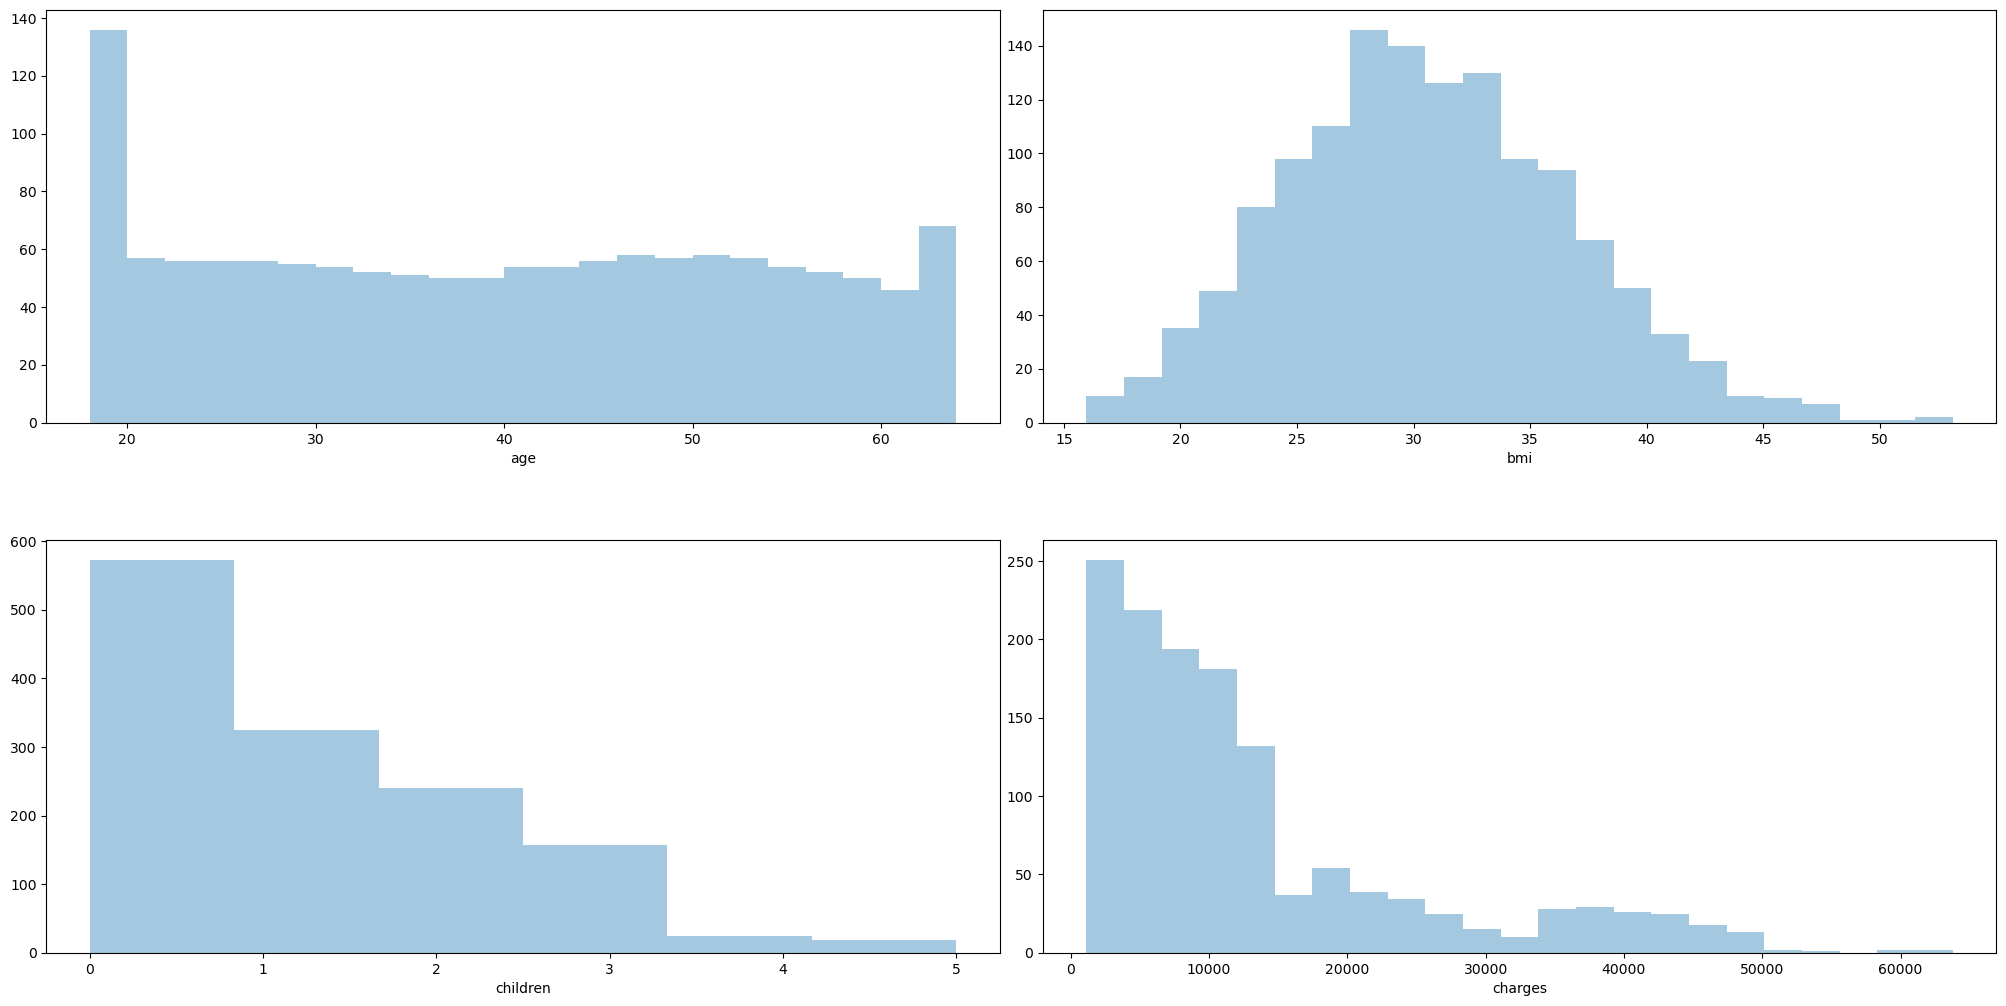

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for num_col in ['age', 'bmi', 'children', 'charges']:
    num_unique_vals = df[num_col].nunique()
    num_bins = np.min([num_unique_vals, 23])
    sns.distplot(df[num_col], ax=axs[index], kde=False, bins=num_bins)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

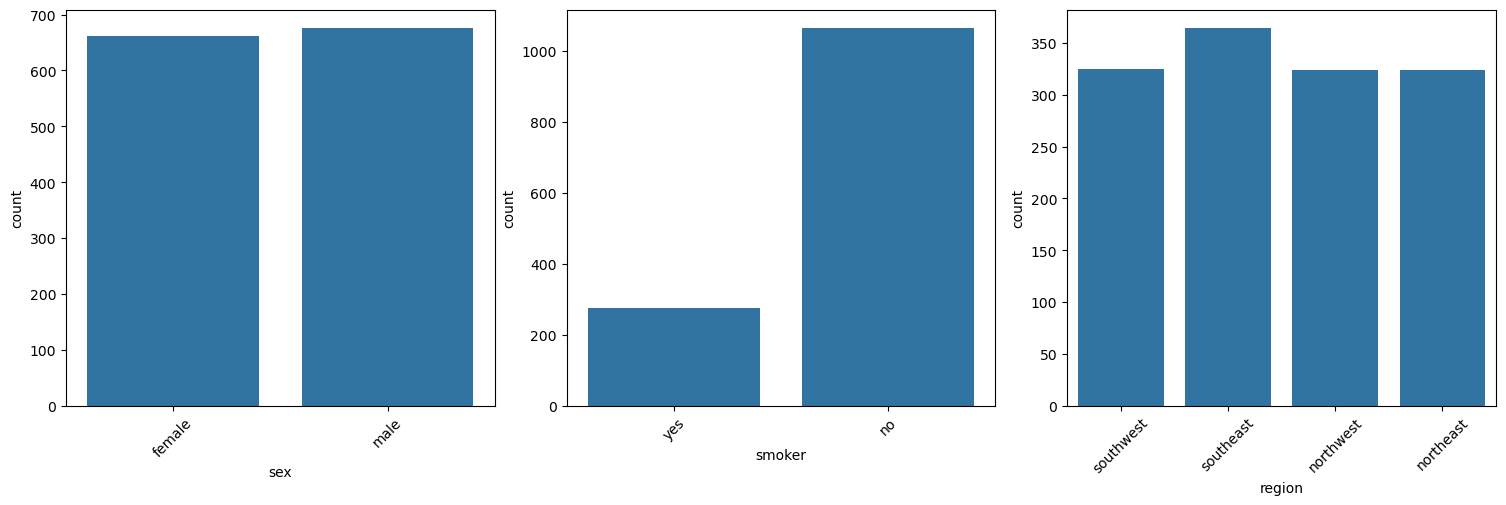

In [12]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
index = 0
axs = axs.flatten()
for num_col in ['sex', 'smoker', 'region']:
    sns.countplot(x=num_col, data=df, ax=axs[index])
    axs[index].tick_params(axis='x', rotation=45)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

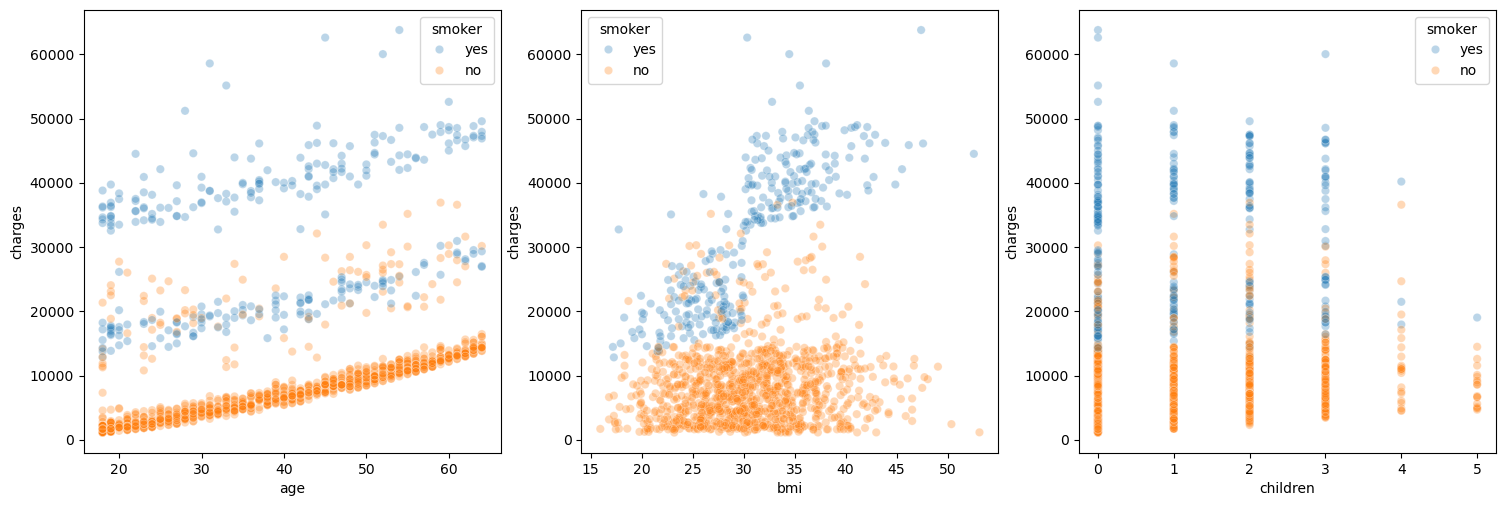

In [13]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
index = 0
axs = axs.flatten()
for num_col in ['age', 'bmi', 'children']:
    sns.scatterplot(x=num_col, y="charges", hue='smoker', data=df, alpha=0.3, ax=axs[index])
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

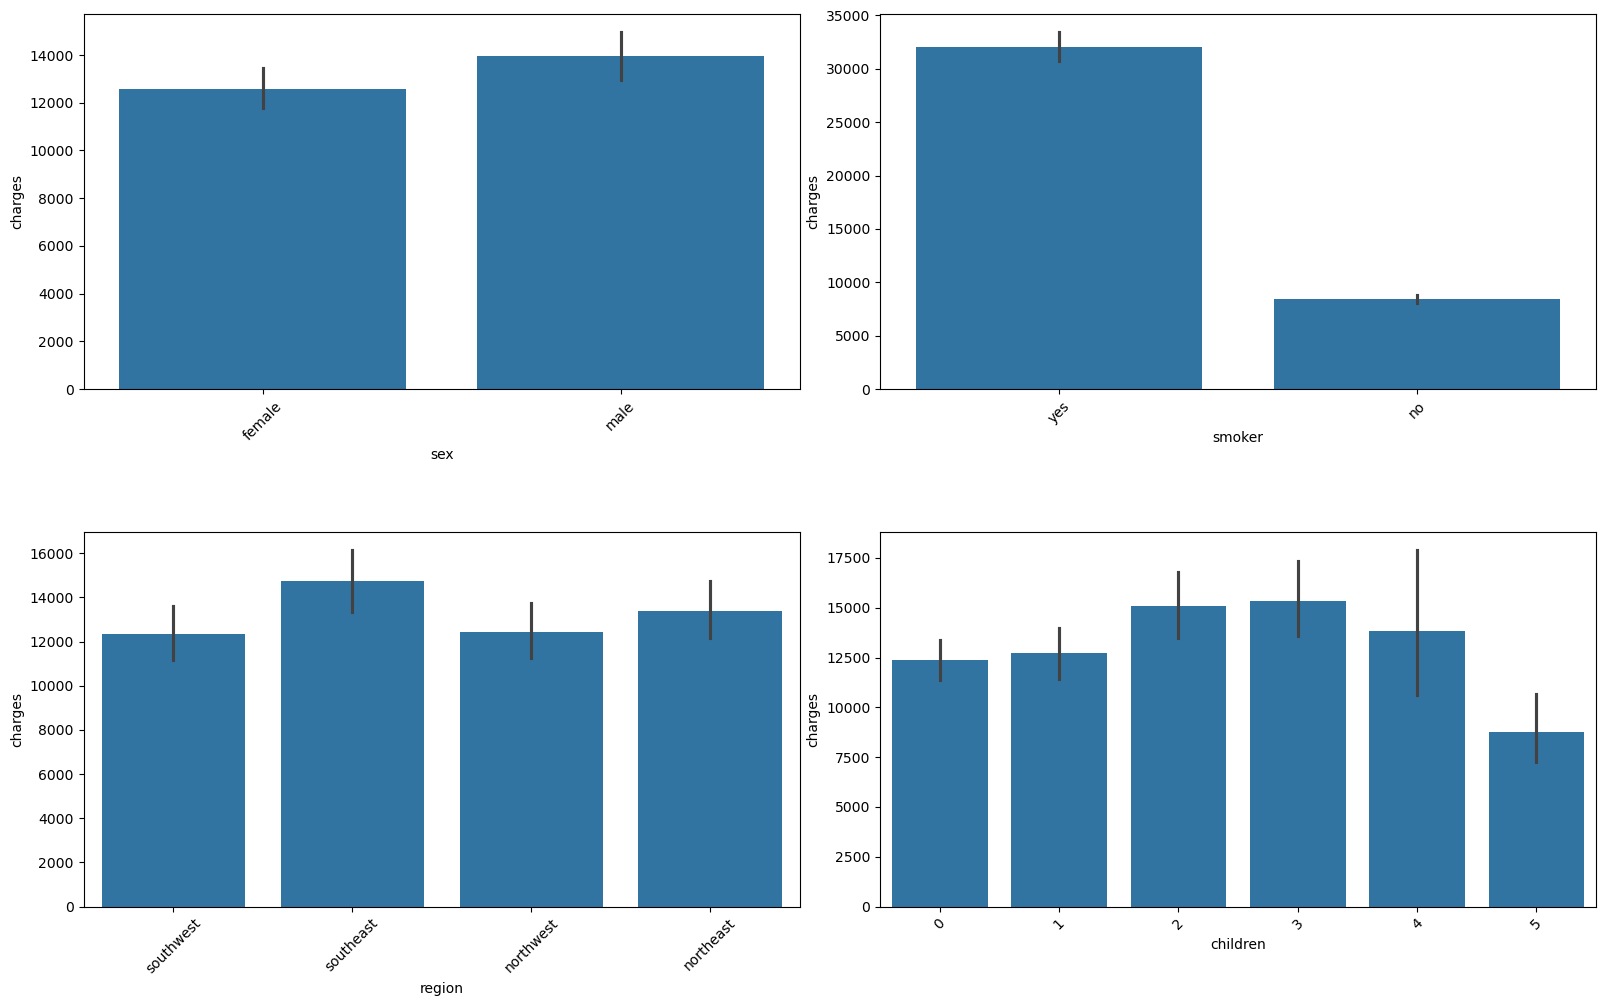

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))
index = 0
axs = axs.flatten()
for num_col in ['sex', 'smoker', 'region', 'children']:
    sns.barplot(x=num_col, y="charges", data=df, ax=axs[index])
    axs[index].tick_params(axis='x', rotation=45)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

<h2>Encoding</h2>

In [16]:
df['sex'] = df['sex'].map({'female': 0, 'male': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

region_encoded_df = pd.get_dummies(df['region'], drop_first=True).astype(int)
df = pd.concat([region_encoded_df, df], axis=1).drop(columns=['region'])

In [17]:
df.head()

,northwest,southeast,southwest,age,sex,bmi,children,smoker,charges
0,0,0,1,19,0,27.900,0,1,16884.92400
1,0,1,0,18,1,33.770,1,0,1725.55230
2,0,1,0,28,1,33.000,3,0,4449.46200
3,1,0,0,33,1,22.705,0,0,21984.47061
4,1,0,0,32,1,28.880,0,0,3866.85520


In [18]:
df.corr().style.background_gradient(cmap='coolwarm')

,northwest,southeast,southwest,age,sex,bmi,children,smoker,charges
northwest,1.000000,-0.345909,-0.320493,0.001495,-0.012482,-0.136138,0.026044,-0.036321,-0.038695
southeast,-0.345909,1.000000,-0.346614,-0.012311,0.017578,0.270057,-0.023492,0.068282,0.073578
southwest,-0.320493,-0.346614,1.000000,0.009415,-0.003767,-0.006211,0.021538,-0.037168,-0.043637
age,0.001495,-0.012311,0.009415,1.000000,-0.019814,0.109344,0.041536,-0.025587,0.298308
sex,-0.012482,0.017578,-0.003767,-0.019814,1.000000,0.046397,0.017848,0.076596,0.058044
bmi,-0.136138,0.270057,-0.006211,0.109344,0.046397,1.000000,0.012755,0.003746,0.198401
children,0.026044,-0.023492,0.021538,0.041536,0.017848,0.012755,1.000000,0.007331,0.067389
smoker,-0.036321,0.068282,-0.037168,-0.025587,0.076596,0.003746,0.007331,1.000000,0.787234
charges,-0.038695,0.073578,-0.043637,0.298308,0.058044,0.198401,0.067389,0.787234,1.000000


In [19]:
def calc_vif(df):
    """
    Calculate the Variance Inflation Factor (VIF) for each feature in the dataset.

    Arguments:
        df (pandas.DataFrame): DataFrame containing the feature set (independent variables).

    Returns:
        pandas.DataFrame: DataFrame containing the VIF for each feature.
    """
    df_with_const = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]

    return vif_data

In [20]:
features_df = df[['smoker', 'age', 'bmi', 'children', 'southwest', 'southeast', 'northwest', 'sex']]  # Replace with your feature columns
vif_result = calc_vif(features_df)

In [21]:
vif_result

,feature,VIF
0,const,35.504594
1,smoker,1.012100
2,age,1.016794
3,bmi,1.106742
4,children,1.004017
5,southwest,1.529044
6,southeast,1.651779
7,northwest,1.517673
8,sex,1.008944


<h1>Initial model and Likelihood-ratio test</h1>

In [23]:
train = df.drop(columns=['charges'])
target = df['charges']

In [24]:
train_with_const = sm.add_constant(train)
model_full = sm.OLS(target, train_with_const).fit()
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.0
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:21:04   Log-Likelihood:                -13538.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1328   BIC:                         2.714e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.194e+04    988.227    -12.079      0.000   -1.39e+04   -9997.900
northwest   -349.2265    476.824     -0.732      0.464   -1284.637     586.183
southeast  -1035.2656    478.867     -2.162      0.031   -1974.684     -95.847
southwest   -960.0814    478.106     -2.008      0.045   -1898.007     -22.156
age          256.7646     11.912     21.555      0.000     233.396     280.133
sex         -129.4815    333.195     -0.389      0.698    -783.128     524.165
bmi          339.2504     28.611     11.857      0.000     283.122     395.379
children     474.8205    137.897      3.443      0.001     204.301     745.340
smoker      2.385e+04    413.348     57.693      0.000     2.3e+04    2.47e+04
==============================================================================
Omnibus:                      299.816   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              716.552
Skew:                           1.211   Prob(JB):                    2.53e-156
Kurtosis:                       5.646   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
def check_significane(train, target, model_full, feature_to_check):
    """
    Check whether feature is significant or not.

    Arguments:
        train (pandas.DataFrame): train dataset.
        target (pandas.Series): target variable.
        modell_full (sm.api.OLS): trained model with all features.
        feature_to_check (str): feature name for which significance should be checked).

    Returns:
        bool: whether feature is significant or not.
    """
    train_without_feature = sm.add_constant(train.drop(columns=[feature_to_check]))
    model_without_feature = sm.OLS(target, train_without_feature).fit()

    lr_statistic = 2 * (model_full.llf - model_without_feature.llf)
    df = 1 # one feature was removed
    p_value = chi2.sf(lr_statistic, df)
    print(f"p-value for feature '{feature_to_check}': {p_value}")

    if p_value < 0.05:
        return True

    return False

In [26]:
significant_features = []
not_significant_features = []
for feature_to_check in train.columns:
    is_significant = check_significane(train=train, target=target, model_full=model_full, feature_to_check=feature_to_check)
    if is_significant:
        significant_features.append(feature_to_check)

    else:
        not_significant_features.append(feature_to_check)

print(f"Significant features: {', '.join(significant_features)}")
print(f"Not significant features: {', '.join(not_significant_features)}")  

p-value for feature 'northwest': 0.4624582344556344
p-value for feature 'southeast': 0.03021085248941613
p-value for feature 'southwest': 0.04407683112742053
p-value for feature 'age': 3.180223066547687e-89
p-value for feature 'sex': 0.6966038325944841
p-value for feature 'bmi': 4.153872068592797e-31
p-value for feature 'children': 0.0005662755769487735
p-value for feature 'smoker': 0.0
Significant features: southeast, southwest, age, bmi, children, smoker
Not significant features: northwest, sex


<h1>Recursive Feature Elimination</h1>

In [28]:

def evaluate_feature_set(rfe_df, features_to_include):
    """
    Evaluates the performance of a linear regression model using cross-validation 
    for given feature set and training dataset by calculating r2-score.

    Arguments:
        rfe_df (pandas.DataFrame): training dataset including target variable.
        features_to_include (list): A list of feature names to be used for training the model.

    Returns:
        float: The average R-squared score from 5-fold cross-validation.
    """
    accuracy_dfs = []
    kf = KFold(n_splits=5, shuffle=True)
    for train_ix, test_ix in kf.split(rfe_df):
        train_df = rfe_df[features_to_include].iloc[train_ix]
        train_target = rfe_df['charges'].iloc[train_ix]

        test_df = rfe_df[features_to_include].iloc[test_ix]
        test_target = rfe_df['charges'].iloc[test_ix]

        model = LinearRegression()
        model.fit(train_df, train_target)
        predictions = model.predict(test_df)

        iter_accuracy_df = test_target.to_frame()
        iter_accuracy_df['prediction'] = predictions
        accuracy_dfs.append(iter_accuracy_df)

    accuracy_df = pd.concat(accuracy_dfs, ignore_index=True)
    r2_score_value = r2_score(accuracy_df['charges'], accuracy_df['prediction'])

    return r2_score_value

In [29]:
def evaluate_feature_exclusions(rfe_df, features_to_evaluate):
    """
    Evaluates the performance of a linear regression model using cross-validation 
    ufor each feature set with N-1 feature by calculating r2-score.

    Arguments:
        rfe_df (pandas.DataFrame): training dataset including target variable.
        features_to_include (list): A list of feature names to be used for training the model.

    Returns:
        float: The average R-squared score for each feature exclusion.
    """
    results = {}
    for feature_to_evaluate in features_to_evaluate:
        evaluation_features = deepcopy(all_features)
        evaluation_features.remove(feature_to_evaluate)
        r2_score_value = evaluate_feature_set(rfe_df=rfe_df, features_to_include=evaluation_features)
        results[feature_to_evaluate] = r2_score_value

    return results

In [30]:
def get_feature_set_validation(rfe_df, validation_df, feature_set):
    """
    Evaluates the performance of a linear regression model on a specified feature set 
    by calculating the R-squared score on the validation dataset and the AIC on the training dataset.

    Arguments:
        rfe_df (pandas.DataFrame): The training dataset, including the target variable ('charges').
        validation_df (pandas.DataFrame): The validation dataset, including the target variable ('charges').
        feature_set (list): A list of feature names to be used for training and predicting.

    Returns:
        dict: A dictionary containing:
            - 'r2_score_validation' (float): The R-squared score of the model on the validation dataset.
            - 'aic' (float): The Akaike Information Criterion (AIC) of the model on the training dataset.
    """
    lr = LinearRegression()
    lr.fit(rfe_df[all_features], rfe_df['charges'])
    predictions = lr.predict(validation_df[feature_set])
    r2_score_validation = r2_score(validation_df['charges'], predictions)

    train_predictions = lr.predict(rfe_df[feature_set])
    train_rss = ((rfe_df['charges'] - train_predictions)**2).sum()
    num_records = len(rfe_df)
    aic = num_records * np.log(train_rss/num_records) + 2*len(feature_set)

    return {'r2_score_validation': r2_score_validation, 'aic': aic}

In [31]:
def get_feature_to_drop(rfe_df, feature_set):
    """
    Evaluates the performance of a feature set by iteratively excluding each feature 
    and calculating the R-squared score. Identifies and returns the feature whose exclusion 
    results in the highest R-squared score.

    Arguments:
        rfe_df (pandas.DataFrame): The dataset including the features and target variable (`charges`).
        feature_set (list): A list of feature names to evaluate for exclusion.

    Returns:
        dict: A dictionary containing:
            - 'iteration_results' (dict): A dictionary with features as keys and their corresponding R-squared scores 
              after exclusion as values.
            - 'feature_to_drop' (str): The name of the feature whose exclusion results in the highest R-squared score.
    """
    eval_results = evaluate_feature_exclusions(rfe_df=rfe_df, features_to_evaluate=feature_set)
    feature_to_drop = None
    max_r2_score = -100
    for feature in eval_results:
        feature_score = eval_results[feature]
        if (max_r2_score < feature_score):
            max_r2_score = feature_score
            feature_to_drop = feature

    return {'iteration_results': eval_results, 'feature_to_drop': feature_to_drop}

In [32]:
rfe_df, validation_df = train_test_split(df, test_size=0.2)
all_features = list(df.drop(columns=['charges']).columns)

rfe_results = {}
while len(all_features) > 0:
    validation_res = get_feature_set_validation(rfe_df=rfe_df, validation_df=validation_df, feature_set=all_features)
    if len(all_features) > 1:
        evaluation_res = get_feature_to_drop(rfe_df=rfe_df, feature_set=all_features)
        feature_to_drop = evaluation_res['feature_to_drop']
    else:
        feature_to_drop = all_features[0]
        evaluation_res = {'feature_to_drop': feature_to_drop, 'iteration_results': {}}
        

    evaluation_res.update(validation_res)
    rfe_results[len(all_features)] = evaluation_res

    all_features.remove(feature_to_drop)

In [33]:
rfe_res = pd.DataFrame.from_dict(rfe_results).T.reset_index().rename(columns={'index': 'num_features'})

In [34]:
rfe_res

,num_features,iteration_results,feature_to_drop,r2_score_validation,aic
0,8,"{'northwest': 0.7642328902674478, 'southeast':...",southeast,0.667264,18565.787403
1,7,"{'northwest': 0.7640463127199346, 'southwest':...",sex,0.665424,18566.806666
2,6,"{'northwest': 0.7645671316257909, 'southwest':...",northwest,0.665354,18564.829393
3,5,"{'southwest': 0.764717499045385, 'age': 0.6653...",southwest,0.665354,18562.829395
4,4,"{'age': 0.6650096087216961, 'bmi': 0.740899888...",children,0.665065,18562.058646
5,3,"{'age': 0.6625650768535498, 'bmi': 0.739663897...",bmi,0.660047,18566.806658
6,2,"{'age': 0.6222025524026987, 'smoker': 0.088909...",age,0.629019,18672.719518
7,1,{},smoker,0.576705,19057.115337


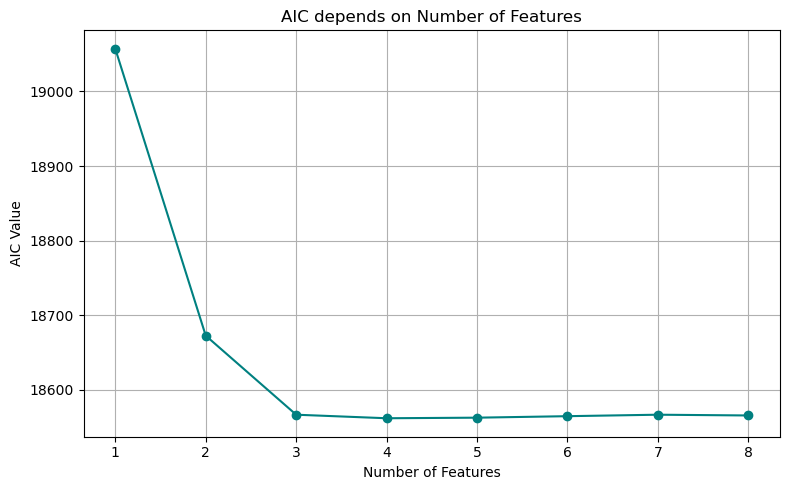

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(rfe_res['num_features'], rfe_res['aic'], marker='o', linestyle='-', color='teal')
plt.title('AIC depends on Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('AIC Value')
plt.grid(True)
plt.tight_layout()
plt.show()

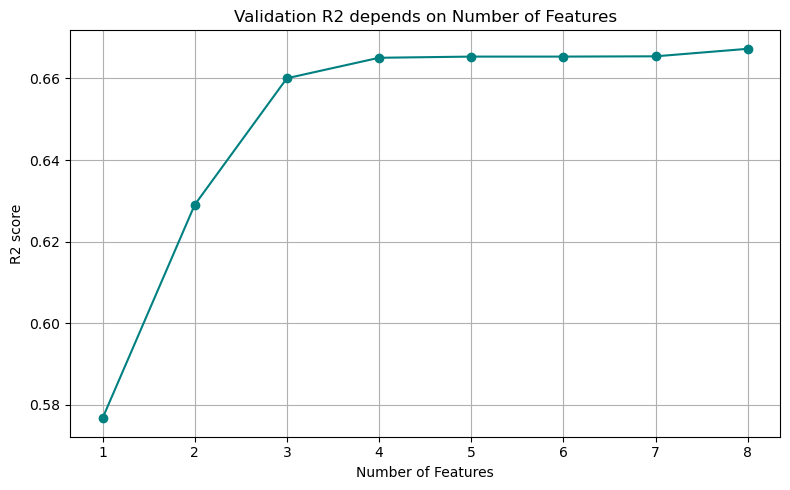

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(rfe_res['num_features'], rfe_res['r2_score_validation'], marker='o', linestyle='-', color='teal')
plt.title('Validation R2 depends on Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('R2 score')
plt.grid(True)
plt.tight_layout()

plt.show()

<h1>Breusch–Pagan test</h1>

In [38]:
features = ['smoker', 'age', 'bmi', 'children', 'southwest', 'southeast']
train = df[features]
target = df['charges']

train_with_const = sm.add_constant(train)
model = sm.OLS(target, train_with_const).fit()
test_result = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, test_result)))

{'LM Statistic': 120.67686495545121, 'LM-Test p-value': 1.1746338009353099e-23, 'F-Statistic': 21.99254262928954, 'F-Test p-value': 8.930496505688945e-25}


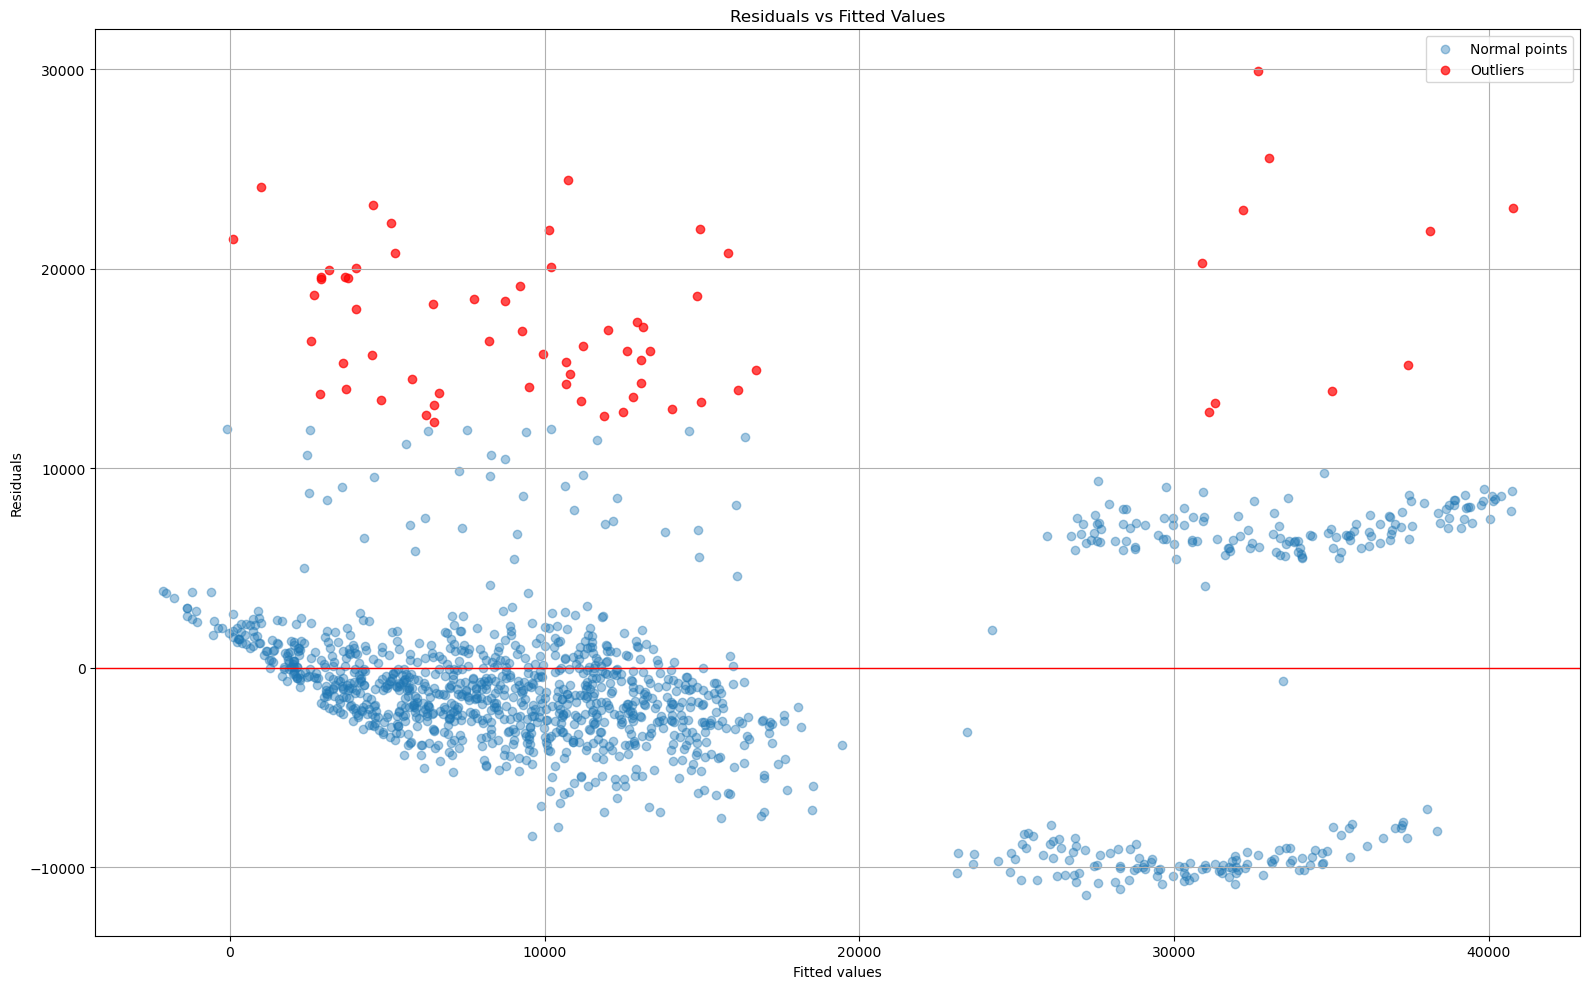

In [39]:
residuals = model.resid
fitted = model.fittedvalues

threshold = 2 * np.std(residuals)
outliers_mask = np.abs(residuals) > threshold

plt.figure(figsize=(16, 10))
plt.scatter(fitted[~outliers_mask], residuals[~outliers_mask], alpha=0.4, label='Normal points')
plt.scatter(fitted[outliers_mask], residuals[outliers_mask], color='red', alpha=0.7, label='Outliers')
plt.axhline(0, color='red', linestyle='-', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h1>Shapiro-Wilk test</h1>

In [41]:
stat, p_value = shapiro(residuals)
print(p_value)

9.594152387033206e-29


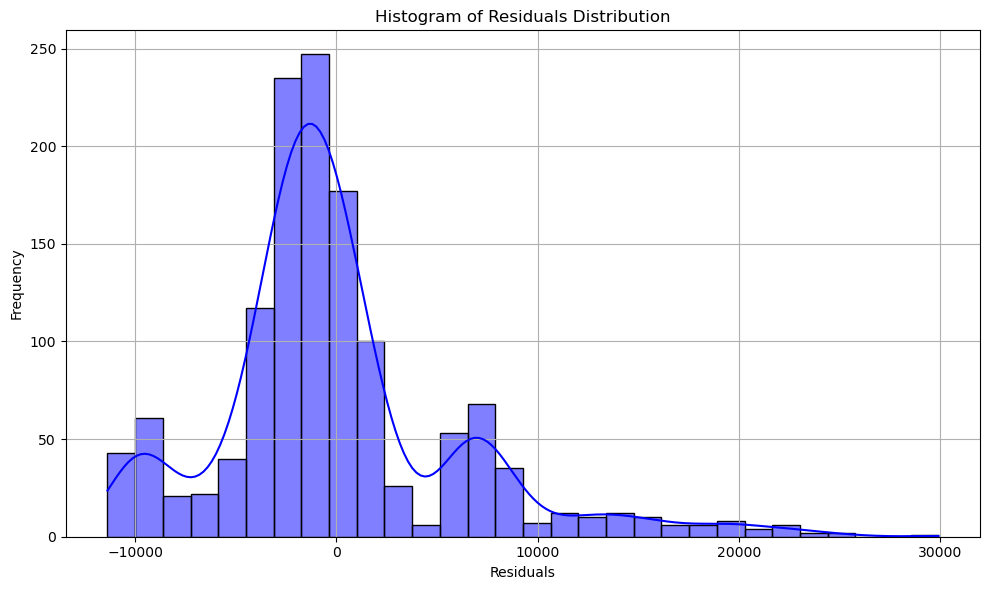

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)  # Add kde=True to overlay a kernel density estimate
plt.title('Histogram of Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

<h1>Box-Cox target transformation</h1>

In [44]:
features = ['smoker', 'age', 'bmi', 'children', 'southwest', 'southeast']
train = df[features]
target, lambda_value = boxcox(df['charges'])

train_with_const = sm.add_constant(train)
box_cox_model = sm.OLS(target, train_with_const).fit()


In [45]:
results = pd.DataFrame({
    'Target': ['Box-Cox Transformed', 'Original'],
    'R^2': [box_cox_model.rsquared, model.rsquared],
    'AIC': [box_cox_model.aic, model.aic],
    'BIC': [box_cox_model.bic, model.bic]
})
results['R^2'] = results['R^2'].round(4)
results['AIC'] = results['AIC'].round(0).astype(int)
results['BIC'] = results['BIC'].round(0).astype(int)

In [46]:
results

,Target,R^2,AIC,BIC
0,Box-Cox Transformed,0.7686,2680,2717
1,Original,0.7506,27091,27127


<h1>Lasso and Ridge</h1>

In [48]:
features = ['smoker', 'age', 'bmi', 'children', 'southwest', 'southeast']

train_df = rfe_df[features]
train_target = rfe_df['charges']
test_df = validation_df[features]
test_target = validation_df['charges']

In [49]:
lr = LinearRegression()
lr.fit(train_df, train_target)
predictions = lr.predict(test_df)
r2_score(test_target, predictions)

0.6673264960506922

In [50]:
results = {}
for alpha in [0.001, 0.01, 0.1, 0.5, 1, 5]:
    lr = Lasso(alpha=alpha)
    lr.fit(train_df, train_target)
    predictions = lr.predict(test_df)
    r2_score_val = r2_score(test_target, predictions)
    print(f'R2 score for alpha={alpha}: {r2_score_val}')
    results[f'{alpha}'] = r2_score_val

results = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={'index': 'alpha', 0: 'r2'})

R2 score for alpha=0.001: 0.667326493565005
R2 score for alpha=0.01: 0.6673264707445687
R2 score for alpha=0.1: 0.6673262448134138
R2 score for alpha=0.5: 0.6673251999381364
R2 score for alpha=1: 0.6673238217329568
R2 score for alpha=5: 0.6673091250273534


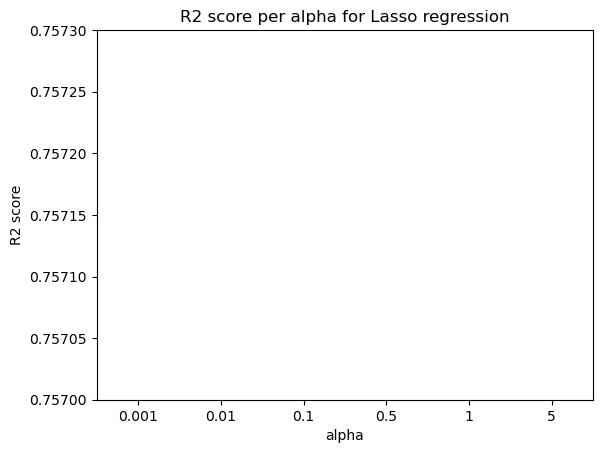

In [51]:
sns.barplot(x='alpha', y='r2', data=results)

# Add title and labels
plt.title('R2 score per alpha for Lasso regression')
plt.xlabel('alpha')
plt.ylabel('R2 score')
plt.ylim(0.757, 0.7573)

# Show the plot
plt.show()

In [52]:
results = {}
for alpha in [0.001, 0.01, 0.1, 0.5, 1, 5]:
    lr = Ridge(alpha=alpha)
    lr.fit(train_df, train_target)
    predictions = lr.predict(test_df)
    r2_score_val = r2_score(test_target, predictions)
    print(f'R2 score for alpha={alpha}: {r2_score_val}')
    results[f'{alpha}'] = r2_score_val

results = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={'index': 'alpha', 0: 'r2'})

R2 score for alpha=0.001: 0.6673269351876141
R2 score for alpha=0.01: 0.6673308854479535
R2 score for alpha=0.1: 0.6673701930372985
R2 score for alpha=0.5: 0.6675406264575339
R2 score for alpha=1: 0.6677439750127458
R2 score for alpha=5: 0.6690026749908304


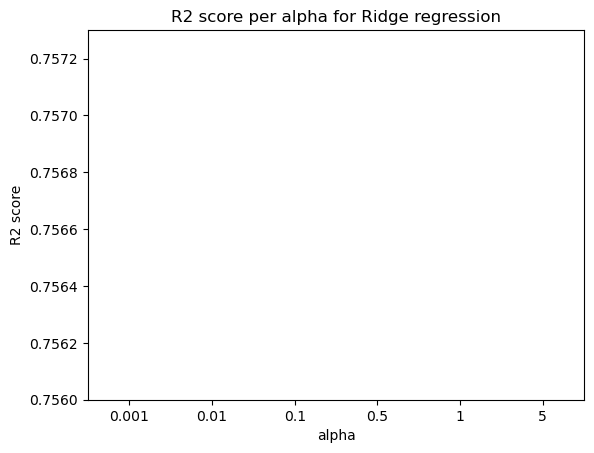

In [53]:
sns.barplot(x='alpha', y='r2', data=results)

# Add title and labels
plt.title('R2 score per alpha for Ridge regression')
plt.xlabel('alpha')
plt.ylabel('R2 score')
plt.ylim(0.756, 0.7573)

# Show the plot
plt.show()

<h1>Non-linearity</h1>

In [55]:
features = ['smoker', 'age', 'bmi', 'children', 'southwest', 'southeast']
feat_eng_features = deepcopy(features)

for feature in ['age', 'bmi', 'children']:
    df[f'squared_{feature}'] = df[feature] * df[feature]
    feat_eng_features.append(f'squared_{feature}')
    df[f'cubed_{feature}'] = df[feature] * df[feature] * df[feature]
    feat_eng_features.append(f'cubed_{feature}')

for i in range(len(features)):
    for j in range(i + 1, len(features)):
        first_feature = features[i]
        second_feature = features[j]
        new_feature = f'{first_feature}_{second_feature}'
        new_feature_series = df[first_feature] * df[second_feature]
        if new_feature_series.nunique() <= 1:
            continue

        else:
            df[new_feature] = new_feature_series
            
        feat_eng_features.append(new_feature)

In [56]:
train = df[feat_eng_features]
target = df['charges']
train_with_const = sm.add_constant(train)
model = sm.OLS(target, train_with_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     281.6
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:21:06   Log-Likelihood:                -13206.
No. Observations:                1337   AIC:                         2.647e+04
Df Residuals:                    1310   BIC:                         2.661e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.952e+04   9338.233      3.162      0.002    1.12e+04    4.78e+04
smoker             -2.045e+04   1851.678    -11.046      0.000   -2.41e+04   -1.68e+04
age                 -174.6633    309.908     -0.564      0.573    -782.633     433.307
bmi                -2804.6075    844.620     -3.321      0.001   -4461.564   -1147.651
children            1720.0661    842.036      2.043      0.041      68.180    3371.952
southwest            572.6426   1909.308      0.300      0.764   -3172.994    4318.279
southeast           2020.1626   2050.532      0.985      0.325   -2002.523    6042.848
squared_age            7.2007      8.055      0.894      0.371      -8.601      23.002
cubed_age             -0.0267      0.066     -0.402      0.688      -0.157       0.104
squared_bmi           97.9707     26.826      3.652      0.000      45.345     150.597
cubed_bmi             -1.0624      0.273     -3.885      0.000      -1.599      -0.526
squared_children    -365.8858    371.325     -0.985      0.325   -1094.342     362.571
cubed_children        41.9582     57.562      0.729      0.466     -70.965     154.881
smoker_age            -4.4539     23.625     -0.189      0.850     -50.802      41.894
smoker_bmi          1468.9172     55.015     26.701      0.000    1360.991    1576.843
smoker_children     -464.5026    285.430     -1.627      0.104   -1024.453      95.447
smoker_southwest     960.4785    854.115      1.125      0.261    -715.104    2636.061
smoker_southeast    -916.5674    787.758     -1.164      0.245   -2461.973     628.838
age_bmi               -0.5345      1.657     -0.323      0.747      -3.785       2.716
age_children          -2.5995      8.773     -0.296      0.767     -19.810      14.611
age_southwest         38.0364     23.909      1.591      0.112      -8.868      84.940
age_southeast         43.4093     23.513      1.846      0.065      -2.717      89.536
bmi_children           2.3658     18.921      0.125      0.901     -34.754      39.486
bmi_southwest        -88.5005     59.713     -1.482      0.139    -205.645      28.644
bmi_southeast       -127.5457     58.196     -2.192      0.029    -241.714     -13.378
children_southwest  -500.9426    267.897     -1.870      0.062   -1026.497      24.611
children_southeast  -323.5557    279.455     -1.158      0.247    -871.783     224.672
==============================================================================
Omnibus:                      733.821   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4650.438
Skew:                           2.575   Prob(JB):                         0.00
Kurtosis:                      10.546   Cond. No.                     8.25e+06
==============================================================================

<h1>Cross-validation</h1>

In [58]:
def calc_aic(df, features):
    """
    Calculate the Akaike Information Criterion (AIC) for the given model based on residuals.

    Arguments:
        df (pandas.DataFrame): The dataset that includes residuals (errors) for the model.
        features (list): List of features used in the model.

    Returns:
        float: The Akaike Information Criterion (AIC) value.
    """
    rss = (df['residual'] * df['residual']).sum()
    num_records = len(df)
    num_parameters = len(features)

    return num_records * np.log(rss/num_records) + 2*num_parameters

def calc_bic(df, features):
    """
    Calculate the Bayesian Information Criterion (BIC) for the given model based on residuals.

    Arguments:
        df (pandas.DataFrame): The dataset that includes residuals (errors) for the model.
        features (list): List of features used in the model.

    Returns:
        float: The Bayesian Information Criterion (BIC) value.
    """
    rss = (df['residual'] * df['residual']).sum()
    num_records = len(df)
    num_parameters = len(features)

    return num_records * np.log(rss/num_records) + num_parameters * np.log(num_records)

def calc_num_outliers(df):
    """
    Calculate the number of outliers (residual is twice times more then its standard deviation) based on the residuals of the model.

    Arguments:
        df (pandas.DataFrame): The dataset containing the residuals for the model.

    Returns:
        int: The number of outliers in the dataset.
    """
    threshold = 2 * np.std(df['residual'])
    num_outliers = len(df.loc[df['residual'].map(np.abs) > threshold])

    return num_outliers

In [59]:
class BoxCoxModel(RegressorMixin, BaseEstimator):
    """
    Box-Cox transformation regression model.
    """
    def __init__(self, **params):
        """
        Construct the object.

        Arguments:
            params (dict): model hyperparameters.
        """
        self._params = params
        algo = params.pop('algo')
        self.algo = algo(**params)
        self.box_cox_lambda = None

    def fit(self, X, y):
        """
        Train the model.

        Arguments:
            X (pandas.DataFrame): training dataset.
            y (pandas.Series): target variable.
        """
        box_cox_y, box_cox_lambda = boxcox(y)
        self.box_cox_lambda = box_cox_lambda

        self.algo.fit(X, box_cox_y)
        
    def predict(self, X):
        """
        Run predictions.

        Arguments:
            X (pandas.DataFrame): dataset to predict.

        Returns:
            predicted values as a pandas.Series.
        """
        predictions = self.algo.predict(X)
        predictions = inv_boxcox(predictions, self.box_cox_lambda)
        
        return predictions

In [60]:
def calc_metrics(accuracy_df):
    """
    Calculate regression metrics base on provided real and predicted values.

    Arguments:
        accuracy_df (pandas.DataFrame): dataset with real and predicted values.

    Returns:
        dictionary with metric names as a keys and related metric values as a dict values.
    """
    r2_score_value = r2_score(accuracy_df['charges'], accuracy_df['prediction'])
    mae = mean_absolute_error(accuracy_df['charges'], accuracy_df['prediction'])
    mse = mean_squared_error(accuracy_df['charges'], accuracy_df['prediction'])
    mape = mean_absolute_percentage_error(accuracy_df['charges'], accuracy_df['prediction'])
    aic = calc_aic(df=accuracy_df, features=features)
    bic = calc_bic(df=accuracy_df, features=features)
    num_outliers = calc_num_outliers(df=accuracy_df)

    output = {
        'r2_score': round(r2_score_value, 6),
        'mae': round(mae, 2),
        'mse': round(mse, 2),
        'mape': round(mape, 6),
        'aic': round(aic, 2),
        'bic': round(bic, 2),
        'num_outliers': num_outliers,
    }

    return output 

In [61]:

def run_cv(df, model_setup):
    """
    Evaluates the performance of a linear regression model using cross-validation 
    for given feature set and training dataset by calculating r2-score.

    Arguments:
        df (pandas.DataFrame): training dataset including target variable.
        model_setup (dict): model settings.

    Returns:
        float: The average R-squared score from 5-fold cross-validation.
    """
    algo = model_setup['algo']
    features = model_setup['features']
    parameters = model_setup['parameters']
    
    accuracy_dfs = []
    kf = KFold(n_splits=10, shuffle=True)
    for train_ix, test_ix in kf.split(df):
        train_df = df[features].iloc[train_ix]
        train_target = df['charges'].iloc[train_ix]

        test_df = df[features].iloc[test_ix]
        test_target = df['charges'].iloc[test_ix]

        model = algo(**parameters)
        model.fit(train_df, train_target)
        predictions = model.predict(test_df)

        iter_accuracy_df = test_target.to_frame()
        iter_accuracy_df['prediction'] = predictions
        accuracy_dfs.append(iter_accuracy_df)

    accuracy_df = pd.concat(accuracy_dfs, ignore_index=True)
    accuracy_df['residual'] = accuracy_df['charges'] - accuracy_df['prediction']
    eval_res = calc_metrics(accuracy_df=accuracy_df)
    
    model_name = model_setup.get('model_name')
    output = {'model_name': model_name}
    output.update(eval_res)

    return output

In [62]:
default_features = ['smoker', 'age', 'bmi', 'children', 'southwest', 'southeast']

lr_box_cox_parameters = {'algo': LinearRegression}

dt_parameters = {
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'criterion': 'squared_error',
    'splitter': 'best'
}

rf_parameters = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'bootstrap': True
}
xgb_parameters = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 5,
    'gamma': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

models_setup = [
    {'model_name': 'linear_regression:default', 'algo': LinearRegression, 'parameters': {}, 'features': default_features},
    {'model_name': 'linear_regression:box_cox', 'algo': BoxCoxModel, 'parameters': lr_box_cox_parameters, 'features': default_features},
    {'model_name': 'lasso_regression:default', 'algo': Lasso, 'parameters': {'alpha': 0.1}, 'features': default_features},
    {'model_name': 'ridge_regression:default', 'algo': Ridge, 'parameters': {'alpha': 0.1}, 'features': default_features},
    {'model_name': 'linear_regression:with_non_linearity', 'algo': LinearRegression, 'parameters': {}, 'features': feat_eng_features},
    {'model_name': 'decision_tree:default', 'algo': DecisionTreeRegressor, 'parameters': dt_parameters, 'features': default_features},
    {'model_name': 'random_forest:default', 'algo': RandomForestRegressor, 'parameters': rf_parameters, 'features': default_features},
    {'model_name': 'xgboost:default', 'algo': XGBRegressor, 'parameters': xgb_parameters, 'features': default_features},
]

In [63]:
outputs = []
for model_setup in models_setup:
    output = run_cv(df=df, model_setup=model_setup)
    outputs.append(output)
    

In [64]:
pd.DataFrame(outputs)

,model_name,r2_score,mae,mse,mape,aic,bic,num_outliers
0,linear_regression:default,0.747841,4201.93,36954249.34,0.424195,23309.48,23340.67,68
1,linear_regression:box_cox,0.577686,4093.66,61890524.31,0.269607,23998.95,24030.14,131
2,lasso_regression:default,0.747803,4201.48,36959695.43,0.423838,23309.68,23340.87,69
3,ridge_regression:default,0.747877,4201.14,36948879.33,0.423499,23309.29,23340.48,66
4,linear_regression:with_non_linearity,0.840630,2915.08,23355828.88,0.310670,22696.02,22727.21,85
5,decision_tree:default,0.821315,2812.55,26186501.33,0.336319,22848.97,22880.16,100
6,random_forest:default,0.844854,2962.31,22736779.94,0.375842,22660.10,22691.29,87
7,xgboost:default,0.858714,2509.86,20705652.70,0.297815,22534.99,22566.18,94


<h1>mlflow</h1>

In [66]:
# !export MLFLOW_TRACKING_URI=http://localhost:5000

In [70]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

current_time = dt.datetime.now(dt.timezone.utc)
exp_name = f'insurance_payments_{current_time.strftime("%Y_%m_%d_%H_%M_%S")}'
mlflow.set_experiment(exp_name)

2025/04/13 13:22:23 INFO mlflow.tracking.fluent: Experiment with name 'insurance_payments_2025_04_13_10_22_23' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/186730331704268193', creation_time=1744539743190, experiment_id='186730331704268193', last_update_time=1744539743190, lifecycle_stage='active', name='insurance_payments_2025_04_13_10_22_23', tags={}>

In [72]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [74]:
def log_box_plots(df):
    """
    Log box-plots for non-binary features.

    Arguments:
        df (pandas.DataFrame): training dataset.
    """
    non_binary_features = ["age", "bmi", "children"]
    non_binary_features = [x for x in non_binary_features if x in df.columns]
    df[non_binary_features].boxplot()
    plt.title("Box Plot of Non-Binary features")
    plt.ylabel("Values")

    image_path = "boxplot.png"
    plt.savefig(image_path)
    plt.close()

    mlflow.log_artifact(image_path)
    os.remove(image_path)

In [76]:
def log_residual_hist(df):
    """
    Log the histogram of residuals.

    Arguments:
        df (pandas.DataFrame): dataset with residuals data.
    """
    sns.histplot(df['residual'], bins=20, kde=False)
    plt.title("Residuals Histogram")
    plt.ylabel("Values")

    image_path = "residuals_hist.png"
    plt.savefig(image_path)
    plt.close()

    mlflow.log_artifact(image_path)
    os.remove(image_path)

In [78]:
def log_qq_plot(df):
    """
    Log the QQ plot of residuals.

    Arguments:
        df (pandas.DataFrame): dataset with residuals data.
    """
    plt.figure(figsize=(6, 6))
    probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")

    image_path = "qq_plot.png"
    plt.savefig(image_path)
    plt.close()

    mlflow.log_artifact(image_path)
    os.remove(image_path)

In [80]:
def run_and_log_model(train_df, test_df, model_setup):
    """
    Evaluates the performance of a linear regression model using cross-validation 
    for given feature set and training dataset by calculating r2-score.

    Arguments:
        df (pandas.DataFrame): training dataset including target variable.
        model_setup (dict): model settings.

    Returns:
        float: The average R-squared score from 5-fold cross-validation.
    """
    algo = model_setup['algo']
    features = model_setup['features']
    parameters = model_setup['parameters']
    model_name = model_setup.get('model_name')

    start_time = dt.datetime.now(dt.timezone.utc)
    
    with mlflow.start_run(run_name=model_name):
        train_target = train_df['charges']
        train_df = train_df[features]
        test_target = test_df['charges']
        test_df = test_df[features]
        
        model = algo(**parameters)
        model.fit(train_df, train_target)
        predictions = model.predict(test_df)

        accuracy_df = test_target.to_frame()
        accuracy_df['prediction'] = predictions
        accuracy_df['residual'] = accuracy_df['charges'] - accuracy_df['prediction']
        
        eval_res = calc_metrics(accuracy_df=accuracy_df)

        signature = infer_signature(train_df, model.predict(train_df))

        for metric in eval_res:
            mlflow.log_metric(metric, eval_res.get(metric))

        end_time = dt.datetime.now(dt.timezone.utc)
        run_time = round((end_time - start_time).seconds + (end_time - start_time).microseconds/1000000, 2)
        mlflow.log_param("run_time", run_time)
        mlflow.log_param("model_type", model.__class__.__name__)
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("num_records_train_dataset", len(train_df))
        mlflow.log_param("num_records_test_dataset", len(test_df))
        
        log_box_plots(df=train_df)
        log_residual_hist(df=accuracy_df)
        log_qq_plot(df=accuracy_df)
        
        mlflow.log_param("hyperparameters", parameters)   
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=model_name,
            signature=signature,
            input_example=train_df,
        )
        

    return

In [82]:
for model_setup in models_setup:
    run_and_log_model(train_df=train_df, test_df=test_df, model_setup=model_setup)

🏃 View run linear_regression:default at: http://127.0.0.1:5000/#/experiments/186730331704268193/runs/81f68a026a944666ab6f20739428d806
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/186730331704268193
🏃 View run linear_regression:box_cox at: http://127.0.0.1:5000/#/experiments/186730331704268193/runs/42b754a45acf46b8ac83ff686fc0fce3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/186730331704268193
🏃 View run lasso_regression:default at: http://127.0.0.1:5000/#/experiments/186730331704268193/runs/7098edac0b3e4590b9be27c8590ce422
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/186730331704268193
🏃 View run ridge_regression:default at: http://127.0.0.1:5000/#/experiments/186730331704268193/runs/0892f743ce374f838cf355139fdafd24
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/186730331704268193
🏃 View run linear_regression:with_non_linearity at: http://127.0.0.1:5000/#/experiments/186730331704268193/runs/8a254a27679e463e838299d2499a4736
🧪 View experi